##  Data Collection

In [106]:
import pandas as pd

df1=pd.read_csv('../Datasets/AAPL.csv')
df1.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [107]:
df1.shape

(1258, 15)

In [108]:
df1.tail(2)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.87,318.66,25672211,316.85,320.89,315.87,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.35,315.77,20450754,318.89,319.23,315.35,315.77,20450754,0.0,1.0


## Price prediction will be done for 'close' column

In [109]:
df2=df1.reset_index()['close']
df2.head()

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

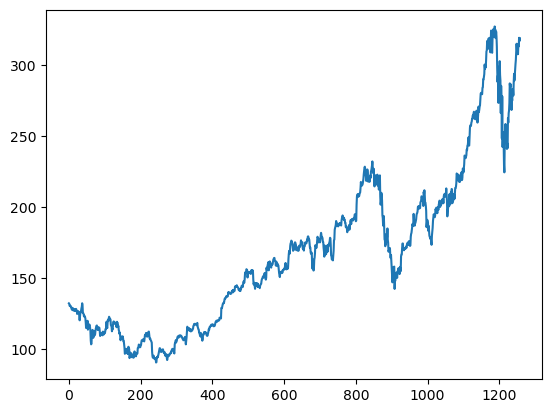

In [110]:
import matplotlib.pyplot as plt
plt.plot(df2)

## As LSTM are sensitive to scale of data so we use `MinMax scaler`.

In [111]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [112]:
df2

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

# Train Test split : A `special type of split`

- It's `TimeSeries Data`.
- It can't be splitted randomly, so cross validation and random_seed not useful.
- It must be splitted considering date.

In [113]:
training_size=int(len(df2)*0.60)
test_size=len(df2)-training_size

training_size,test_size

(754, 504)

In [114]:
train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]

# Coverting Array of values into dataset matrix

- for example if our data has-
- train data -> `1,2,3,4,5,6,7,8,9`
- then it must be made below type dataset-
```
        features        target
        1,2,3,4           5
        2,3,4,5           6
        3,4,5,6           7
        4,5,6,7           8
        5,6,7,8           9
```


In [115]:
def create_dataset(dataset, time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [116]:
time_step=150
X_train, y_train=create_dataset(train_data,time_step)
X_test, y_test=create_dataset(test_data,time_step)

In [117]:
X_train

array([[0.17607447, 0.17495567, 0.16862282, ..., 0.07713417, 0.07468547,
        0.06957697],
       [0.17495567, 0.16862282, 0.1696994 , ..., 0.07468547, 0.06957697,
        0.07768302],
       [0.16862282, 0.1696994 , 0.16727181, ..., 0.06957697, 0.07768302,
        0.07168792],
       ...,
       [0.27953221, 0.27721017, 0.28138985, ..., 0.41294436, 0.4057249 ,
        0.41307101],
       [0.27721017, 0.28138985, 0.29359115, ..., 0.4057249 , 0.41307101,
        0.40804695],
       [0.28138985, 0.29359115, 0.29608207, ..., 0.41307101, 0.40804695,
        0.40517605]])

In [118]:
X_train.shape,y_train.shape

((603, 150), (603,))

In [119]:
X_test.shape,y_test.shape

((353, 150), (353,))

### training data must be in `3-dimension` for LSTM so we will `reshape` our trainins and testing data.

In [120]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

## Creating Stacked LSTM model

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input

model = Sequential()
model.add(Input(shape=(150, 1)))  # Define input shape explicitly
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile('adam', 'mse')


In [122]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 150, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 150, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=64,verbose=1)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - loss: 0.0255 - val_loss: 0.0983
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - loss: 8.7491e-04 - val_loss: 0.0050
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - loss: 6.4469e-04 - val_loss: 0.0075
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - loss: 6.0898e-04 - val_loss: 0.0047
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - loss: 5.5785e-04 - val_loss: 0.0044
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - loss: 5.3658e-04 - val_loss: 0.0037
Epoch 9/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 5.5785e-04 - val_loss: 0.0037
Epoch 10/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - loss: 5.1469e-04 - val_loss: 0.0035
Epoch 11/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 5.2061e-04 - val_loss: 0.0040
Epoch 12/

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - loss: 1.8659e-04 - val_loss: 0.0029
Epoch 67/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step - loss: 2.4845e-04 - val_loss: 0.0068
Epoch 68/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - loss: 2.2397e-04 - val_loss: 0.0029
Epoch 69/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step - loss: 2.7198e-04 - val_loss: 0.0051
Epoch 70/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - loss: 2.3378e-04 - val_loss: 0.0050
Epoch 71/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - loss: 2.0549e-04 - val_loss: 0.0039
Epoch 72/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - loss: 1.7077e-04 - val_loss: 0.0059
Epoch 73/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - loss: 1.8474e-04 - val_loss: 0.0057
Epoch 74/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 1.6339e-04 - val_loss: 0.0048
Epoch 75/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 385ms/step - loss: 1.9439e-04 - val_loss: 0.0044
Epoch 76/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - loss: 1.8144e-04 - val_loss: 0.0044
E

Epoch 131/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - loss: 1.1479e-04 - val_loss: 0.0035
Epoch 132/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - loss: 1.3801e-04 - val_loss: 0.0017
Epoch 133/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - loss: 1.1175e-04 - val_loss: 0.0030
Epoch 134/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - loss: 1.0921e-04 - val_loss: 0.0025
Epoch 135/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - loss: 1.0008e-04 - val_loss: 0.0026
Epoch 136/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - loss: 1.0886e-04 - val_loss: 0.0017
Epoch 137/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - loss: 1.0835e-04 - val_loss: 0.0028
Epoch 138/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - loss: 1.1099e-04 - val_loss: 0.0019
Epoch 139/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - loss: 1.4415e-04 - val_loss: 0.0022
Epoch 140/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - loss: 1.3493e-04 - val_loss: 0.0033
Epoch 141/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - loss: 1.3293e

## Prediction and Metrics evaluation

In [124]:
predicted_train=model.predict(X_train)
predicted_test=model.predict(X_test)

# inverse transform
predicted_train=scaler.inverse_transform(predicted_train)
predicted_test=scaler.inverse_transform(predicted_test)

# root mean square error
import math 
from sklearn.metrics import mean_squared_error
training_rmse=math.sqrt(mean_squared_error(y_train,predicted_train))
testing_rmse=math.sqrt(mean_squared_error(y_test,predicted_test))

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [125]:
training_rmse,testing_rmse

(137.20895664811343, 226.54009500463656)

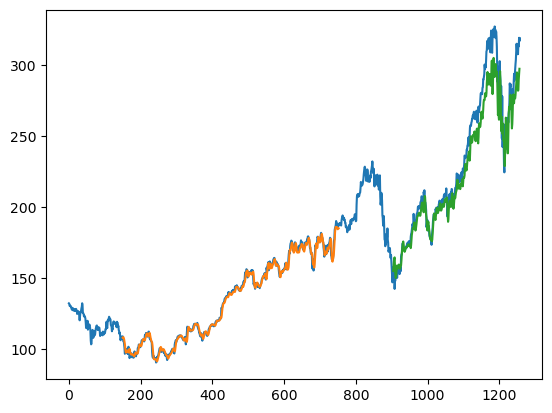

In [126]:
### Plotting 
# shift train predictions for plotting
look_back=150
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(predicted_train)+look_back, :] = predicted_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(predicted_train)+(look_back*2)+1:len(df2)-1, :] = predicted_test
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Prediction for future 30 days

In [127]:
len(test_data)

504

In [128]:
x_input=test_data[354:].reshape(1,-1)
x_input.shape

(1, 150)

In [129]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [130]:
lst_output=[]
n_steps=150
i=0
while(i<30):
    
    if(len(temp_input)>150):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.8600695729255676], [0.7781393527984619], [0.6697193384170532], [0.5718063712120056], [0.5045079588890076], [0.4738888442516327], [0.47509288787841797], [0.49920153617858887], [0.537614643573761], [0.582619845867157], [0.6268580555915833], [0.6633340716362], [0.6861798167228699], [0.691792368888855], [0.6798529624938965], [0.653782844543457], [0.6202481389045715], [0.5875356793403625], [0.5631909370422363], [0.5519848465919495], [0.5552263855934143], [0.5713946223258972], [0.5971824526786804], [0.6282511353492737], [0.6596726775169373], [0.686368465423584], [0.7037585377693176], [0.70860356092453], [0.6998254060745239], [0.6790087819099426]]


In [131]:
day_new=np.arange(1,151)
day_pred=np.arange(151,181)

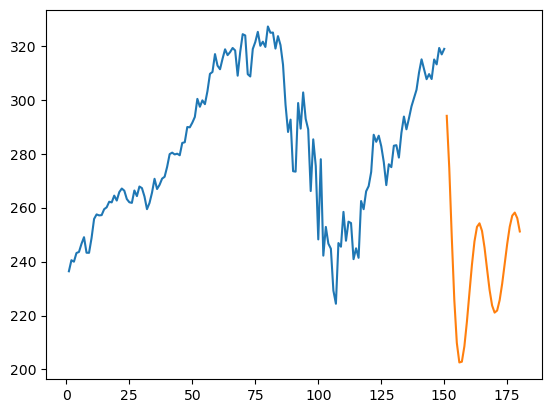

In [132]:
plt.plot(day_new,scaler.inverse_transform(df2[1108:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

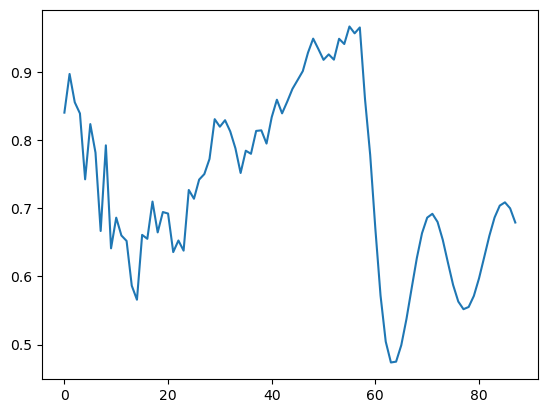

In [133]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

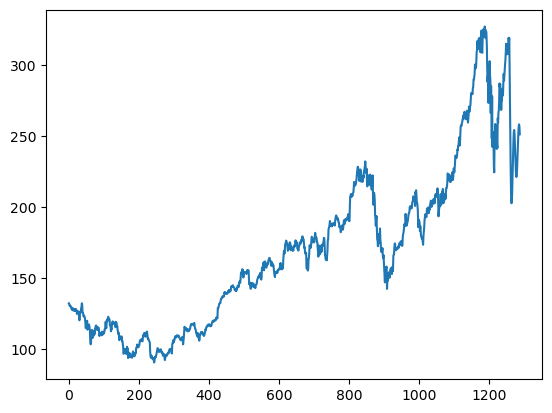

In [134]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)